# Introduction to Text Processing

In this primer we will go over some common text processing techniques on raw data in order to extract useful information and turn them into a form suitable for data exploration and analysis.

## 1. Regular expression (regex)
### 1.1. Motivation
Regular expression is a powerful tool for parsing unstructured data, where the basic idea is to specify a syntax string that defines which portions (groups) of the input string we want to capture, and what to do with the captured groups. As a simple example, let's say we have an HTML paragraph tag `<p>hello world</p>` and want to extract its inner text "hello world", we can specify a "rule" of what qualifies as inner text, and use regex to search for it.

In [136]:
import re
text = "<p>hello world</p>"
re.findall("<p>([\w\s]*)</p>", text)

['hello world']

Here the rule is that anything after `<p>`, before `</p>` and contains either an alphanumeric character (specified by `\w`) or a space (specified by `\s`) any number of times (specified by `*`) should be captured. The substring "hello world" satisfies all of the above conditions, so it was returned.

Naturally, if we know that the opening tag is always `<p>` and closing tag is always `</p>`, we could have just removed them from the string to get the inner text, without having to use regex. Where regex truly shines is in complex real-world HTML code that typically looks like

```
<div class="container" id="title">
    <div class="row">
        <p onclick = "execute();">
            <img src="pic.png"/>
            Click me
            <br />
        </p>
    </div>
</div>
```

The nested structure, in addition to custom attributes in each tag, means that it is very difficult to capture the inner text "Click me" using standard string operations. To understand how regex can be applied to tackle this problem, we will go over some basic concepts as follows.

### 1.2. Regex syntax

At its core, regex is about specifying what you want to capture. Here are a number of common character sets you should get familiar with:

<br>

| Usage 	| Syntax 	| Note 	|
|-	|-	|-	|
| Match a single character 'x' 	| `x` 	|  	|
| Match one among 'x' or 'y' or 'z' 	| `[xyz]` 	|  	|
| Match one among possibly multi-character groups | `abc\|xyz` | This matches either the string 'abc' or 'xyz' | |
| Match any character except 'x' and 'y' and 'z' 	| `[^xyz]` 	|  	|
| Match any digit 	| `\d` 	| equivalent to `[0-9]` 	|
| Match any alphanumeric character 	| `\w` 	| equivalent to `[a-zA-z0-9_]`, note that the underscore character is also included 	|
| Match any kind of whitespace 	| `\s` 	| equivalent to `[ \t\n\r\f\v]`, note the first character in the bracket is a standard white space 	|
| Match any character 	| `.` 	|  	|

You can search online for "python regex spreadsheet" to find more comprehensive syntax tables, such as [this one](https://www.debuggex.com/cheatsheet/regex/python). The ones listed above are those that you would frequently encounter.

In addition, there are some common modifiers that you can append next to each character set to specify how many instances of that set you want to capture:

<br>

| Usage 	| Modifier 	|
|-	|-	|
| Match only once 	| None 	|
| Match zero or one time 	| `?` 	|
| Match zero or more times 	| `*` 	|
| Match one or more time 	| `+` 	|
| Match exactly $n$ times 	| `{n}` 	|

For example, in 1.1 we have used `[\w\s]*` to mean "zero or more times of either an alphanumeric character or a space." This would also match the empty inner text in `<p></p>`; if we want to specify that there should be some text between the `p` tags, we can instead use `[\w\s]+`.

Note that here we have treated some characters as special indicators (i.e., metacharacters) of a match group or modifier. For example, `\d` means "match a number" and not "match the forward slash followed by the character d." What if we want the latter instead of the former? The answer is that we can just escape these special characters by putting a backslash before it, e.g., `\\d` would do the job. More generally, here are the list of metacharacters that you need to escape if you want to match them:

`. ^ $ * + ? { } [ ] \ | ( )`

You can then use the above character sets in combination with one of the compiled regex methods:
* `.match(s, pos)` matches the start of the substring `s[pos:]` with the specified expression
* `.search(s)` finds the first match with the specified expression anywhere in the input string `s`
* `.finditer(s)` iterates over all matches in the input string `s`
* `.findall(s)` returns a list of all matches in the input string `s`
* `.sub(new_exp, s)` finds all matches in the input string `s` and replaces each match with `new_exp`.

Here are some simple examples of these functions; we will get into more involved examples later on.

In [141]:
# find a pattern of "hello" followed by a space followed by alphanumeric chars
regex_exp = re.compile("hello\s\w+")
s = "  hello world!! hello friend"

match_example = regex_exp.match(s, pos = 2)
print("\n.match example\n", match_example)

# find the first pattern of "hello" followed by a space followed by alphanumeric chars
search_example = regex_exp.search(s)
print("\n.search example\n", search_example)

# iterate over all matches
for iter_example in regex_exp.finditer(s):
    print("\n.finditer example\n", iter_example)
    
# list all matches
print("\n")
findall_example = regex_exp.findall(s)
print(".findall example\n", findall_example)

# substitute all "hello <some words>" with "holla"
sub_example = regex_exp.sub("holla", s)
print("\n.sub example\n", sub_example)


.match example
 <re.Match object; span=(2, 13), match='hello world'>

.search example
 <re.Match object; span=(2, 13), match='hello world'>

.finditer example
 <re.Match object; span=(2, 13), match='hello world'>

.finditer example
 <re.Match object; span=(16, 28), match='hello friend'>


.findall example
 ['hello world', 'hello friend']

.sub example
   holla!! holla


Note that the return value of `.match` or `.search.`, as well as each member in the iterator of `.finditer`, is a `re.Match` object, in which the `span` attribute indicates the start and end index of the matched expression in the input string, and the `match` object specifies what the matched expression is. We can also get these two attributes programmatically:

In [33]:
print(match_example.span())
print(match_example.group())

(4, 15)
hello world


### 1.3. Grouping
In the example above, we have specified our target pattern as "`hello` followed by a space followed by alphanumeric characters," and we get the matched string as `hello world`. While this is useful, one could argue that we only care about what actually follows the `hello` (i.e., the ` world` portion), not the entire matched pattern `hello world`. More generally, we would like a flexible way to control what gets captured. This is where grouping comes in handy; we can specify the group that we want to capture by wrapping it in `( )`.

In [138]:
# only capture what follows "hello"
regex_exp_group = re.compile("hello(\s\w+)")
print(regex_exp_group.findall(s))

# only captures what follows "hello" and the space
regex_exp_group = re.compile("hello\s(\w+)")
print(regex_exp_group.findall(s))

[' world', ' friend']
['world', 'friend']


Grouping becomes particularly powerful is in cases of backreferencing, where we can use the notation `\k` to refer to the `k`-th group that has been captured (indexed from 1). For example, the regular expression

`hello\s(\w+)\shello\s(\1)`

would match the pattern of: `hello` followed by a space, followed by a word, followed by a space, followed by *the same word captured earlier*.

In [140]:
regex_exp_backref = re.compile(r"hello\s(\w+)\shello\s\1")

# "world" is captured in \w+ and matched with \1, so there is a match
print(regex_exp_backref.findall("hello world hello world"))

# "friend" is different from "world" so there is no match
print(regex_exp_backref.findall("hello world hello friend"))

['world']
[]


In practice we rarely see repeated data like this, but `\k` is also very useful in string substitution, as you can specify how each captured group is to be replaced. For example, the following `.sub` call would replace all instances of `axb` with `axxb`, where `x` is any number of digits:

In [77]:
regex_exp_backref_sub = re.compile("a(\d*)b")
regex_exp_backref_sub.sub(r"a\1\1b", "a00b a111b b2a")

'a0000b a111111b b2a'

### 1.4. Regex nuances
While the above background information should be sufficient to get you started, we want to highlight a number of important nuances that you should keep in mind while reading and writing regex:

### 1.4.1. Compiled regex methods vs module-level functions
You can create a pattern object `p` by calling `p = re.compile(<regex expression>)`. This will allow you to use methods from `p` such as `p.search(s)`, `p.match(s)`, `p.findall(s)` to carry out regex operations on an input string `s`. On the other hand, you can skip the creation of `p` altogether by using the equivalent module-level functions `re.search(<regex expression>, s)`, `re.match(<regex expression>, s)` and `re.findall(<regex expression>, s)`. You may have noticed that we used both approaches in our earlier examples.

In general, which approach to use is up to your personal preference -- there is no performance difference between the two. If you anticipate using the same regex expression multiple times, you should save it in a compiled object so that you don't need to hard-code a (complex) string more than once, which may leave room for errors. Also note that some compiled methods are more flexible than their module-level counterparts. For example, the method `.match` supports the parameter `pos` that specifies the starting position to look at, while the module-level `re.match` function does not have this parameter.

### 1.4.2. Ordering and greedy matching
While regular expressions, like math expressions, are typically evaluated from left to right, there are certain operations, in particular the `OR` operation (`|`), that take priority. For example, the regex `abc|def` would match either the string `abc` or `def`, and not "`ab` followed by `c` or `d` followed by `ef`".

In [115]:
print(re.match("abc|def", "abcghik"))
print(re.match("abc|def", "abdef"))

<re.Match object; span=(0, 3), match='abc'>
None


For the latter case, we can use a round bracket to overwrite priority, again just like in a mathematical expression: `ab(c|d)ef`.

In [116]:
print(re.match("ab(c|d)ef", "abdef"))

<re.Match object; span=(0, 5), match='abdef'>


On the other hand, this would also create a capture group. For example, if you have a regex like

`ab(c|d)ef\s(\d+)`

then to refer to what is captured in `(\d+)`, you would use `\2` instead of `\1`, because `\1` points to `(c|d)`. If you do not want `(c|d)` to be captured, you can append `?:` to the beginning of the bracket: `ab(?:c|d)ef`.

Another point to keep in mind is that regular expression, by default, tries to capture as much text as possible, especially when using wildcards such as `*`. For example,

In [118]:
re.match("<.*>", "<a href='#'>hello</a>")

<re.Match object; span=(0, 21), match="<a href='#'>hello</a>">

we see that appplying `<.*>` to `<a href='#'>hello</a>` matches the entire string instead of only the opening tag `<a href='#'>`. For the latter behavior, we can disable greedy matching by appending a `?` after the matching set:

In [119]:
re.match("<.*?>", "<a href='#'>hello</a>")

<re.Match object; span=(0, 12), match="<a href='#'>">

You can also indicate the exact scope where greedy matching should be disabled by wrapping it in `( )`, e.g., `<(.*?)>`. Note that this again creates a group, so a workaround would be `<(?:.*?)>`.

### 1.4.3. Dealing with backslash
We have seen earlier the set of metacharacters that each has to be escaped when matching via a preceding backslash `\`. The problem, however, is that the backslash used for this escaping also needs to be escaped. As an example, let's say we want to identify substrings that indicate LaTeX command (of the form `\{keyword}`, e.g., `\newline`) in a given source file, we can do

In [127]:
print(re.search("\\\w+", "\section{Introduction}"))

None


Interestingly, this returns None, even though we expect that the first `\\` would be able to capture the `\` in `\section`. As it turns out, the correct regex should be

In [128]:
print(re.search("\\\\\w+", "\section{Introduction}"))

<re.Match object; span=(0, 8), match='\\section'>


In other words, we need *five* backslashes in total to capture `\section`. The reason is that character escaping is not unique to regex, but also occurs in regular Python string. For example, if you enclose your string with double quotes "..." and the string content also has the " character, you have to escape it:

In [130]:
print("\"hello world\"")

"hello world"


Therefore, what happens in the above example is that the regex string `"\\\\\w+"` undergoes two layers:
1. The Python interpreter sees the regex string as `(\\)(\\)(\w+)` and treats the first two groups as "two escaped backslash characters," so it passes `\\\w+` to the next layer.
1. The regex parser sees `\\\w+` as `(\\)(\w+)` and treats the first group as "one escaped backslash character," so it looks for the pattern `(\)(\w+)`, .i.e., one backslash character followed by a word. This matches the `\section` portion from the original input.

This is obviously cumbersome to deal with, especilly given that regex strings are already inherently complex. A workaround is to skip the interpreter level, by using the *raw string* keyword in Python (i.e., adding a `r` before the string definition): 

In [135]:
print(re.search(r"\\\w+", "\section{Introduction}"))

<re.Match object; span=(0, 8), match='\\section'>


With the first layer skipped, we can naturally use `\\\w+`, knowing that it will only be handled by the reger parser as it step 2 above. In general, you are encouraged to use this option to keep your regex strings tidy. 

### 1.5. Miscellaneous examples
To close off this topic, we present a number of examples that employ the regex functionalities we have covered above.

* Given a list of country names where some also have their affiliations included in round brackets, e.g., `Denmark (Europe)`, remove the affiliation so that only the country name remains (you have performed this task in Project 2).

In [82]:
countries = ["France", "Denmark (Europe)", "United Kingdom (Europe)", "Falkland Islands (Islas Malvinas)"]
regex_exp = r"\s\((\w+|\s)+\)"
[re.sub(regex_exp, "", country) for country in countries]

['France', 'Denmark', 'United Kingdom', 'Falkland Islands']

* Check if a string is a valid email address of the form `<username>@<domain>`, e.g., `abc@andrew.cmu.edu`. For each valid email, extract the username and the domain.

In [104]:
emails = ["abc@andrew.cmu.edu", "xyz!?@hotmail.com", "a.b.c@gmail.com", "hello-world@yahoo.com"]
regex_exp = r"([\w.-]+)@([\w.-]+)"
for e in emails:
    match = re.match(regex_exp, e)
    if match:
        print(f"{e} is valid email, username is {match.group(1)}, domain is {match.group(2)}")
    else:
        print(f"{e} is not valid email")

abc@andrew.cmu.edu is valid email, username is abc, domain is andrew.cmu.edu
xyz!?@hotmail.com is not valid email
a.b.c@gmail.com is valid email, username is a.b.c, domain is gmail.com
hello-world@yahoo.com is valid email, username is hello-world, domain is yahoo.com


* Find all instances of three consecutive and identical alphanumeric characters in a given string, e.g., `aaa`, `111`, and replace each instance with only the starting character.

In [111]:
strs = ["aaabbb", "aaa bb cc111", "___!!!", "ababab"]
regex_exp = r"(\w)\1\1"
[re.sub(regex_exp, r"\1", s) for s in strs]

['ab', 'a bb cc1', '_!!!', 'ababab']

* Capitalize every character except the character `o` before or after a space in a given string:

In [113]:
strs = ["hello world", " hello  world ", "hello! o"]
regex_exp = r"(\s[^o]|[^o]\s)"
[re.sub(regex_exp, lambda match: match.group(1).upper(), s) for s in strs]

['hello World', ' Hello  worlD ', 'hello! o']

* Check if the string length is a prime number. See [here](https://iluxonchik.github.io/regular-expression-check-if-number-is-prime/) for explanations.

In [95]:
strs = ["." * i for i in range(1, 10)]
regex_exp = r"^.?$|^(..+?)\1+$"
for s in strs:
    print("the length of string", s, "is a prime number:", re.match(regex_exp, s) is None)

the length of string . is a prime number: False
the length of string .. is a prime number: True
the length of string ... is a prime number: True
the length of string .... is a prime number: False
the length of string ..... is a prime number: True
the length of string ...... is a prime number: False
the length of string ....... is a prime number: True
the length of string ........ is a prime number: False
the length of string ......... is a prime number: False


As an exercise, try parsing the HTML code at the beginning to get the "Click me" text.

Above is only a brief introduction to regex. You can refer to the official [documentation](https://docs.python.org/3/library/re.html) and [tutorial](https://docs.python.org/3/howto/regex.html) for more advanced techniques.

## 2. Common language processing tasks
While regex is powerful for text processing, it views text data from a purely computer-based perspective, as a sequence of characters. To make this data usable for analysis, we typically need to apply some of our linguistic understanding in the processing steps. For example, we know that "city" and "cities" should not be treated as completely distinct words, as the latter is simply the plural form of the former. We also know that the word "the" appears a lot in English but is not meaningful on its own, so it should probably not be considered for analysis.

This leads us to the question of how *language* processing -- as opposed to text processing -- can be carried out. Fortunately, there has been a tremendous amount of work done in this area which we can leverage. In particular, we will be using the [natural language toolkit (NLTK)](http://www.nltk.org/) library to handle text and natural language data.

In [145]:
import nltk

### 2.1. String tokenization
Tokenization is the process of splitting an input string into a list of tokens, where each token is a linguistic unit in speech or writing. For example, the string sentence "Today is a good day", when tokenized, would yield

In [146]:
nltk.word_tokenize("Today is a good day")

['Today', 'is', 'a', 'good', 'day']

At first glance this may look like a standard string `.split()` function, although `.split()` by default does not yield tokens in a strict linguistic sense, because it only uses the space as delimiter:

In [147]:
print("hello, how are you?".split())
print(nltk.word_tokenize("hello, how are you?"))

['hello,', 'how', 'are', 'you?']
['hello', ',', 'how', 'are', 'you', '?']


Here we see that `hello` and `,` get grouped together in `split`, whereas `word_tokenize` knows about separating them; the same goes for `you` and `?`. We could, of course, include `,` and `?` and all other linguistic delimiters as a parameter to `split` in order to have it replicate the functionality of `word_tokenize`, but it is more convenient to just use nltk's function.

### 2.2. Stopwords

Stop words are words which are filtered before or after a natural language processing task because they are not inherently meaningful, or may interfere with the processing task. Typically, stopwords are those which appear very frequently in text due to their grammatical roles, e.g., `a`, `the`, `in`. However, there is no universal list of stopwords for a given language; each tool may maintain its own set of stopwords. The English stopwords in nltk are:

In [150]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")
print(english_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Note that all of these words are in lowercase, so you should also convert any input string to lowercase before examining stopwords. Filtering stopwords typically comes together with tokenization -- we split an input string into a list of tokens, then remove tokens that are considered stopwords:

In [152]:
s = "The quick brown fox jumps over the lazy dog"
[word for word in nltk.word_tokenize(s.lower()) if word not in english_stopwords]

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']

### 2.3. Stemming and lemmatization

Due to the English grammar rules, our text data may contain different forms of the same word, such as "be", "was", and "been." Different forms of the same words typically contribute the same meaning to the overall text (though there are, of course, exceptions, such as "historic" vs "historical"), so in many cases we want to replace all of these derivative forms with one base form, instead of treating them as distinct terms. Both *stemming* and *lemmatization* refer to this same form reduction task, although they do so in different manners.

Stemming uses a heuristic process to cut down the tails of certain words that may indicate the derivative forms, e.g., `sses` would becomes `ss`, and `ies` would become `i`. On the other hand, lemmatization uses more involved morphological analysis to retrieve the word base form. NLTK offers several different corpuses, each with its own lemmatizer. A popular choice is the WordNet corpus:

In [153]:
from nltk.stem.wordnet import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

After creating a `lemmatizer` object, we can simply call `.lemmatize` on an input token:

In [180]:
print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("been", pos = "v"))

cat
be


Note that in some cases we also need to specify the `pos` (part-of-speech) parameter, which indicates the word classes (e.g., noun, verb, adjective, adverb), because there are different reduction strategies depending on the word class. For example, lemmatizing nouns typically involve cutting down plurals, while lemmatizing verb can also mean converting from past tense to present tense.

By default, the `pos` parameter takes the value `"n"`, i.e., the input token is assumed to be a noun. Therefore, if the token turns out to not be a noun, lemmatizing will not make any changes:

In [181]:
print(lemmatizer.lemmatize("been"))

been


The possible input values for `pos` include `a`, `r`, `n` and `v`; their meanings are as follows.

In [194]:
wordnet._FILEMAP

{'a': 'adj', 'r': 'adv', 'n': 'noun', 'v': 'verb'}

The question, then, is how do we provide the appropriate tag to each word (`a`, `r`, `n` or `v`) in our corpus in an automatic manner? To help with this, nltk has a function `pos_tag` that can output a list of potential part-of-speech tags for a given list of words (note that the input is always a list):

In [187]:
nltk.download('averaged_perceptron_tagger')
print(nltk.pos_tag(["clear"]))
print(nltk.pos_tag(nltk.word_tokenize("John's big idea isn't all that bad.")))

[('clear', 'JJ')]
[('John', 'NNP'), ("'s", 'POS'), ('big', 'JJ'), ('idea', 'NN'), ('is', 'VBZ'), ("n't", 'RB'), ('all', 'PDT'), ('that', 'DT'), ('bad', 'JJ'), ('.', '.')]


We see that the output is a list of tuples, where each tuple contains one word token and its part-of-speech tag. Here the tags are based on the [Penn Treebank Tag Set](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) by default, e.g., `NNP` means "proper noun, single" and `POS` means "possessive ending." A different tagset would yield a different schema; for example, the `universal` tagset has fewer tags, which you can see the mapping for [here](https://www.nltk.org/_modules/nltk/tag/mapping.html):

In [192]:
nltk.download('universal_tagset')
print(nltk.pos_tag(nltk.word_tokenize("John's big idea isn't all that bad."), tagset = "universal"))

[('John', 'NOUN'), ("'s", 'PRT'), ('big', 'ADJ'), ('idea', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('all', 'DET'), ('that', 'DET'), ('bad', 'ADJ'), ('.', '.')]


To sum up, here is the standard workflow of text processing using nltk:
1. Split document into sentences
1. Tokenize each sentence
1. Get the part-of-speech tag for each token
1. Lemmatize each token based on its part-of-speech tag

Note that in step 4, the input tag to the `pos` parameter of `lemmatize` should be one of `a`, `r`, `n` or `v`. On the other hand, the tag from step 3 may have different formats depending on the tagset (e.g., `NN` for Treebank and `NOUN` for `universal`). Therefore, you have to construct your own part-of-speech tag mapping between step 3 and 4. You will get to practice with this workflow in Project 3.

## 3. Feature construction

After having our text data processed, the next step is to construct numerical features that can be used for data analyses. In this primer, we will consider some simple techniques that rely only on word frequencies in a corpus. More advanced word embedding techniques will be covered in Project 4.

### 3.1. Bag of words
A bag of words model is essentially a dictionary that maps each unique word in a corpus to the number of times it appears in the corpus. The rationale is that knowing which words are in the corpus, along with their frequencies, can already give us a sense of the corpus' topic or meaning. For example, if the set of movie reviews for a given movie contains a lot of negative expressions (e.g., "bad", "disappointing", "boring"), we can already tell that the movie was not well received.

A common way to visualize a bag of words model is through word cloud, which shows the most common words and use the word sizes to indicate their relative frequencies. As an example, let's try visualizing a bag of words model of the first Harry Potter book:

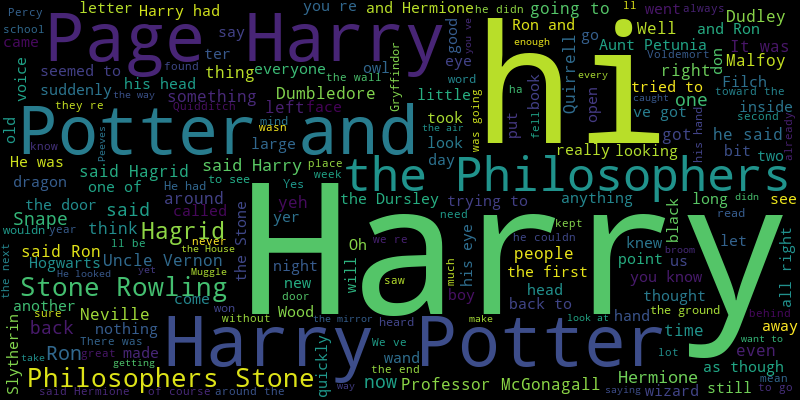

In [199]:
from wordcloud import WordCloud
import requests

source = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"
harry_potter = re.sub(r"\s+", " ", requests.get(source).text)
wc = WordCloud(width=800,height=400).generate(harry_potter)
wc.to_image()

### 3.2. Term-frequency matrix
While the bag of word model is useful for visual and qualitative analysis, it is fairly primitive for numerical analysis, because we only get a one-dimensional list of frequency counts, one for each word. Furthermore, frequency may be tricky to interpret: if our corpus has 100 documents, but the most frequent word in the corpus appears only in 3 documents, then it may not be that representative of the corpus.

As an improvement, we can construct a bag of word model for each member document, instead of for the whole corpus. Assuming our corpus has $m$ documents and $n$ unique words, this approach would yield an $m \times n$ matrix $TF$ where $TF_{ij}$ denotes the frequency of word $j$ in document $i$; $TF$ is typically called the *term-frequency* matrix. We have now represented our text data in a format that is more common for data analysis and modeling: an input matrix $TF \in \mathbb{R}^{m \times n}$. If our goal is to classify the documents into some categories, for example, we can also build the output vector $Y \in \mathbb{C}^{n \times 1}$ (where $C$ is the set of categories), and train some classification models using $TF$ and $Y$. In this case, each document is an observation, and each word plays the role of a feature.

As an example, if our corpus is

```python
corpus = [
    "hello world",
    "hello hello friend",
    "I have no friend"
]
```

then our term-frequency matrix $TF \in \mathbb{R}^{3 \times 6}$ is
<br>

|  	| hello 	| world 	| friend 	| I 	| have 	| no 	|
|-	|-	|-	|-	|-	|-	|-	|
| Document 1 	| 1         	| 1         	| 0 	| 0 	| 0 	| 0 	|
| Document 2 	| 2                   	| 0 	| 1         	| 0 	| 0 	| 0 	|
| Document 3 	| 0 	| 0 	| 1         	| 1         	| 1         	| 1         	|

### 3.3. Term frequency - inverse document frequency
While we have now split each word's frequency among all the documents, the problem remains that words which appear very frequently (such as stopwords) will dominate the analysis (from a numerical perspective, these words are the features with much larger values than other features). Therefore, we would like to "normalize" these high frequency values in some ways. One typical approach is to consider the *inverse document frequency* of a word:

$$\text{IDF}_j = \log \left( \frac{\# \text{ of documents}}{\# \text{ of documents with word } j} \right).$$

Note that if a word appears in every document, its IDF will be 0; if it appears in only one document, its frequency will be the $\log(m)$, where $m$ is the number of documents. We can then normalize these IDF terms with the corresponding entries in the TF matrix to obtain a TF-IDF matrix, where

$$\text{TF-IDF}_{ij} = \text{TF}_{ij} \times \text{IDF}_j.$$

Above is a somewhat intuitive explanation of TF-IDF, but it also has close connections with information theory (hence the $\log$ in the IDF terms), which you can read more on the [Wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

As an example, using the corpus above, we can compute the IDF of each word as:

$$IDF_1 = \log(3/2), \ IDF_2 = \log(3), IDF_3 = \log(3/2), \ IDF_4 = IDF_5 = IDF_6 = \log(3).$$

The resulting TF-IDF matrix is then

<br>

|  	| hello 	| world 	| friend 	| I 	| have 	| no 	|
|-	|-	|-	|-	|-	|-	|-	|
| Document 1 	| 0.405 	| 1.099 	| 0 	| 0 	| 0 	| 0 	|
| Document 2 	| 0.810 	| 0 	| 0.405 	| 0 	| 0 	| 0 	|
| Document 3 	| 0 	| 0 	| 0.405 	| 1.099 	| 1.099 	| 1.099 	|

In Project 3, you will be asked to implement the function to construct this TF-IDF matrix.


For the next step, we can then treat this matrix as a feature matrix $X \in \mathbb{R}^{3 \times 6}$ with 3 observations and 6 features. If we also have a label vector for all the documents $Y \in \mathbb{C}^{3 \times 1}$ for some label set $C$ (for example, whether the document is a spam email or not), it is now possible to train a machine learning model with input $X$ and output $Y$. Intuitively speaking, we are trying to predict whether a given document is a spam email based on the TF-IDF value of each unique word in it. This process will be covered in Project 4.